In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Add Bayesian-and-novelty directory to the PYTHONPATH
import sys
import os
sys.path.append(os.path.realpath('../../..'))

# Autoreload changes in utils, etc.
%load_ext autoreload
%autoreload 2

from novelty.utils.metrics import plot_roc, plot_prc
from novelty.utils.metrics import get_summary_statistics
from novelty.utils.metrics import html_summary_table

In [2]:
# Training settings
BATCH_SIZE = 128
EPOCHS = 200
LR = 0.1
MOMENTUM = 0.9
NO_CUDA = False
SEED = 1
CLASSES = 80
MODEL_PATH_ROOT = './weights/wrn-28-10-cifar80'
MODEL_PATH = MODEL_PATH_ROOT + '.pth'

# MNIST mean and stdevs of training data by channel
CHANNEL_MEANS = (129.38447088003159/255, 124.15443912148476/255, 112.92168706655502/255)
CHANNEL_STDS = (68.1681901216507/255, 65.38242280483246/255, 70.28767839074135/255)

# Plot ROC and PR curves
PLOT_CHARTS = True

# ODIN parameters
TEMP = 1000.
NOISE_MAGNITUDE = 0.0012

## Training and Testing functions

In [3]:
from novelty.utils import Progbar


def train(model, device, train_loader, optimizer, epoch):
    progbar = Progbar(target=len(train_loader.dataset))

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        progbar.add(len(data), [("loss", loss.item())])

In [4]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = F.log_softmax(model(data), dim=1)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_acc))
    
    return test_loss, test_acc

## Load CIFAR80

In [5]:
DATA_DIR = '/media/tadenoud/DATADisk/datasets'
from src.wide_resnet import Wide_ResNet

torch.manual_seed(SEED)

use_cuda = not NO_CUDA and torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Dataset transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS)
])

# Load training and test sets
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(os.path.join(DATA_DIR, 'cifar80/train'), transform=transform),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(os.path.join(DATA_DIR, 'cifar80/test'), transform=transform),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

## Initialize model and optimizer

In [6]:
# Create model instance
model = Wide_ResNet(28, 10, 0.0, CLASSES)

# Move model to available GPUs
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

print("Using", torch.cuda.device_count(), "GPUs")
model = model.to(device)

# Initialize optimizer
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(EPOCHS*0.5), int(EPOCHS*0.75)], gamma=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

| Wide-Resnet 28x10
Using 1 GPUs


## Optimization loop

In [7]:
if os.path.exists(MODEL_PATH):
    # load previously trained model:
    model.load_state_dict(torch.load(MODEL_PATH))

else:
    best_loss = float("inf")
    
    # Training loop
    for epoch in range(EPOCHS):
        print("Epoch:", epoch)
        scheduler.step()
        
        # Print the learning rate
        for param_group in optimizer.param_groups:
            print('Learning rate:', param_group['lr'])
        
        train(model, device, train_loader, optimizer, epoch)
        loss, acc = test(model, device, test_loader)
        
        # Checkpoint the model parameters
        if loss < best_loss:
            torch.save(model.state_dict(), "{}_epoch{}.pth".format(MODEL_PATH_ROOT, epoch))
            best_loss = loss
            

    # save the model 
    torch.save(model.state_dict(), MODEL_PATH)

Epoch: 0
Learning rate: 0.1
 13696/118799 [==>...........................] - ETA: 16:34 - loss: 3.9556

Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/.virtualenvs/ml/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tadenoud/.virtualenvs/ml/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/tadenoud/.virtualenvs/ml/lib/python3.5/site-packages/torch/utils/data/dataloader

Traceback (most recent call last):
  File "/home/tadenoud/.virtualenvs/ml/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-d60b038e05d2>", line 17, in <module>
    train(model, device, train_loader, optimizer, epoch)
  File "<ipython-input-3-c2bc161f64ab>", line 8, in train
    for batch_idx, (data, target) in enumerate(train_loader):
  File "/home/tadenoud/.virtualenvs/ml/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 280, in __next__
    idx, batch = self._get_batch()
  File "/home/tadenoud/.virtualenvs/ml/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 259, in _get_batch
    return self.data_queue.get()
  File "/usr/lib/python3.5/queue.py", line 164, in get
    self.not_empty.wait()
  File "/usr/lib/python3.5/threading.py", line 293, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exce

KeyboardInterrupt: 

## ODIN prediction functions

In [ ]:
from torch.autograd import Variable


def predict(model, data, device):
    model.eval()
    data = data.to(device)
    outputs = model(data)
    outputs = outputs - outputs.max(1)[0].unsqueeze(1)  # For stability
    return F.softmax(outputs, dim=1)


def predict_temp(model, data, device, temp=1000.):
    model.eval()
    data = data.to(device)
    outputs = model(data)
    outputs /= temp
    outputs = outputs - outputs.max(1)[0].unsqueeze(1)  # For stability
    return F.softmax(outputs, dim=1)


def predict_novelty(model, data, device, temp=1000., noiseMagnitude=0.0012):
    model.eval()

    # Create a variable so we can get the gradients on the input
    inputs = Variable(data.to(device), requires_grad=True)

    # Get the predicted labels
    outputs = model(inputs)
    outputs = outputs / temp
    outputs = F.log_softmax(outputs, dim=1)

    # Calculate the perturbation to add to the input
    maxIndexTemp = torch.argmax(outputs, dim=1)
    labels = Variable(maxIndexTemp).to(device)
    loss = F.nll_loss(outputs, labels)
    loss.backward()

    # Normalizing the gradient to binary in {0, 1}
    gradient = torch.ge(inputs.grad.data, 0)
    gradient = (gradient.float() - 0.5) * 2

    # Normalize the gradient to the same space of image
    for channel, (mean, std) in enumerate(zip(CHANNEL_MEANS, CHANNEL_STDS)):
        gradient[0][channel] = (gradient[0][channel] - mean) / std

    # Add small perturbations to image
    # TODO, this is from the released code, but disagrees with paper I think
    tempInputs = torch.add(inputs.data, -noiseMagnitude, gradient)

    # Get new outputs after perturbations
    outputs = model(Variable(tempInputs))
    outputs = outputs / temp
    outputs = outputs - outputs.max(1)[0].unsqueeze(1)  # For stability
    outputs = F.softmax(outputs, dim=1)

    return outputs

## Evaluate method on outlier datasets

In [ ]:
def get_max_model_outputs(data_loader, device):
    """Get the max softmax output from the model in a Python array.

    data_loader: object
        A pytorch dataloader with the data you want to calculate values for.

    device: object
        The CUDA device handle.
    """
    result = []
    
    for data, target in data_loader:
        # Using regular model
        p = predict(model, data, device)
        max_val, label = torch.max(p, dim=1)
        # Convert torch tensors to python list
        max_val = list(max_val.cpu().detach().numpy())
        result += max_val

    return result


def get_max_odin_outputs(data_loader, device, temp=1000., noiseMagnitude=0.0012):
    """Convenience function to get the max softmax values from the ODIN model in a Python array.
    
    data_loader: object
        A pytorch dataloader with the data you want to calculate values for.
        
    device: object
        The CUDA device handle.
        
    temp: float, optional (default=1000.)
        The temp the model should use to do temperature scaling on the softmax outputs.
        
    noiseMagnitude: float, optional (default=0.0012)
        The epsilon value used to scale the input images according to the ODIN paper.
    """
    result = []
    
    for data, target in data_loader:
        # Using ODIN model
        p = predict_novelty(model, data, device, temp=temp, noiseMagnitude=noiseMagnitude)
        max_val, label = torch.max(p, dim=1)
        # Convert torch tensors to python list
        max_val = list(max_val.cpu().detach().numpy())
        result += max_val

    return result

In [ ]:
import pandas as pd

# Build results table
results = {
    "WRN-28-10": {
        "inlier_name": "CIFAR80",
        "outliers": {}
    },
    "WRN-28-10-ODIN": {
        "inlier_name": "CIFAR80",
        "outliers": {}
    }
}

df = pd.DataFrame(columns=['auroc', 'aupr_in', 'aupr_out', 'fpr_at_95_tpr', 'detection_error'],
                  index=['imagenet_crop', 'imagenet_resize', 'lsun_crop', 'lsun_resize', 
                         'isun_resize', 'gaussian', 'uniform', 'cifar20'])

### Process Inliers

In [11]:
num_inliers = test_loader.dataset.test_data.shape[0]

# Get predictions on in-distribution images
cifar_model_maximums = get_max_model_outputs(test_loader, device)

### Tiny Imagenet (Crop)

In [12]:
directory = os.path.join(DATA_DIR, 'tiny-imagenet-200/test')

# Dataset transformation
transform_crop = transforms.Compose([
    transforms.RandomCrop([32, 32]),
    transforms.ToTensor(),
    transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS)
])

# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
imagenet_crop_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(directory, transform=transform_crop),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_imagenet_crop = len(imagenet_crop_loader.dataset.imgs)

# Get predictions on in-distribution images
imagenet_crop_model_maximums = get_max_model_outputs(imagenet_crop_loader, device)

temp = 1000
eps = 0.0002
cifar_odin_maximums = get_max_odin_outputs(test_loader, device, temp=temp, noiseMagnitude=eps)
imagenet_crop_odin_maximums = get_max_odin_outputs(imagenet_crop_loader, device, temp=temp, noiseMagnitude=eps)


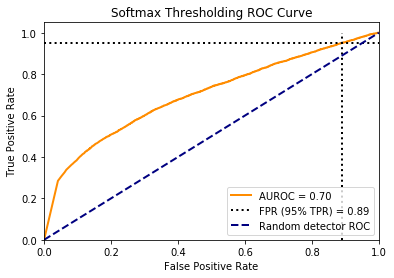

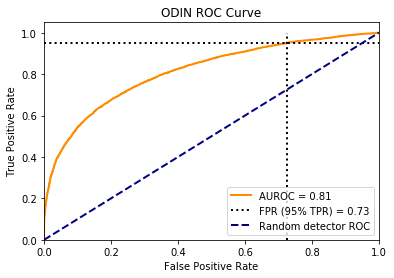

In [13]:
labels = [1] * num_inliers + [0] * num_imagenet_crop
predictions = cifar_model_maximums + imagenet_crop_model_maximums
predictions_odin = cifar_odin_maximums + imagenet_crop_odin_maximums

results["WRN-28-10"]["outliers"]["Imagenet (crop)"] = get_summary_statistics(predictions, labels)
results["WRN-28-10-ODIN"]["outliers"]["Imagenet (crop)"] = get_summary_statistics(predictions_odin, labels)

df.loc['imagenet_crop'] = pd.Series(results["WRN-28-10-ODIN"]["outliers"]["Imagenet (crop)"])

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve")

### Tiny Imagenet (Resize)

In [14]:
directory = os.path.join(DATA_DIR, 'tiny-imagenet-200/test')

# Dataset transformation
transform_resize = transforms.Compose([
    transforms.Resize([32, 32]),
    transforms.ToTensor(),
    transforms.Normalize(CHANNEL_MEANS, CHANNEL_STDS)
])

# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
imagenet_resize_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(directory, transform=transform_resize),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_imagenet_resize = len(imagenet_resize_loader.dataset.imgs)

# Get predictions on in-distribution images
imagenet_resize_model_maximums = get_max_model_outputs(imagenet_resize_loader, device)

temp = 1000
eps = 0.0004
cifar_odin_maximums = get_max_odin_outputs(test_loader, device, temp=temp, noiseMagnitude=eps)
imagenet_resize_odin_maximums = get_max_odin_outputs(imagenet_resize_loader, device, temp=temp, noiseMagnitude=eps)

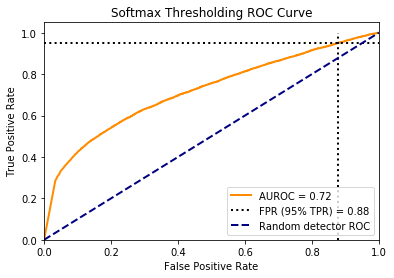

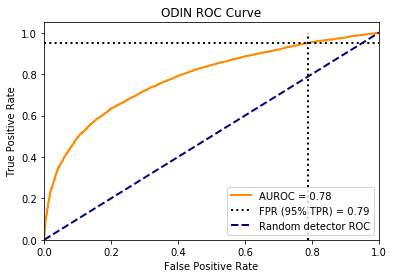

In [15]:
labels = [1] * num_inliers + [0] * num_imagenet_resize
predictions = cifar_model_maximums + imagenet_resize_model_maximums
predictions_odin = cifar_odin_maximums + imagenet_resize_odin_maximums

results["WRN-28-10"]["outliers"]["Imagenet (resize)"] = get_summary_statistics(predictions, labels)
results["WRN-28-10-ODIN"]["outliers"]["Imagenet (resize)"] = get_summary_statistics(predictions_odin, labels)

df.loc['imagenet_resize'] = pd.Series(results["WRN-28-10-ODIN"]["outliers"]["Imagenet (resize)"])

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve")

### LSUN (Crop)

In [16]:
lsun_directory = '/media/tadenoud/DATADisk/datasets/lsun'

# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
lsun_crop_loader = torch.utils.data.DataLoader(
    datasets.LSUN(lsun_directory, classes='test', transform=transform_crop),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_lsun_crop = len(lsun_crop_loader.dataset)

# Get predictions on in-distribution images
lsun_crop_model_maximums = get_max_model_outputs(lsun_crop_loader, device)

temp = 1000
eps = 0.0002
cifar_odin_maximums = get_max_odin_outputs(test_loader, device, temp=temp, noiseMagnitude=eps)
lsun_crop_odin_maximums = get_max_odin_outputs(lsun_crop_loader, device, temp=temp, noiseMagnitude=eps)

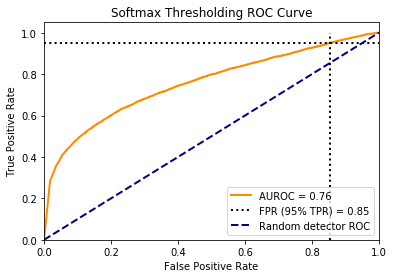

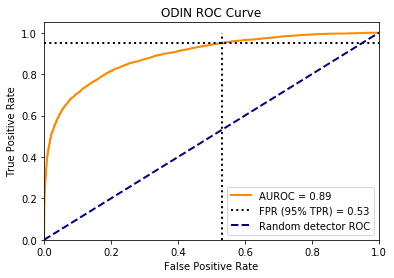

In [17]:
labels = [1] * num_inliers + [0] * num_lsun_crop
predictions = cifar_model_maximums + lsun_crop_model_maximums
predictions_odin = cifar_odin_maximums + lsun_crop_odin_maximums

results["WRN-28-10"]["outliers"]["LSUN (crop)"] = get_summary_statistics(predictions, labels)
results["WRN-28-10-ODIN"]["outliers"]["LSUN (crop)"] = get_summary_statistics(predictions_odin, labels)

df.loc['lsun_crop'] = pd.Series(results["WRN-28-10-ODIN"]["outliers"]["LSUN (crop)"])

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve")

### LSUN (Resize)

In [18]:
# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
lsun_resize_loader = torch.utils.data.DataLoader(
    datasets.LSUN(lsun_directory, classes='test', transform=transform_resize),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_lsun_resize = len(lsun_resize_loader.dataset)

# Get predictions on in-distribution images
lsun_resize_model_maximums = get_max_model_outputs(lsun_resize_loader, device)

temp = 1000
eps = 0.0002
cifar_odin_maximums = get_max_odin_outputs(test_loader, device, temp=temp, noiseMagnitude=eps)
lsun_resize_odin_maximums = get_max_odin_outputs(lsun_resize_loader, device, temp=temp, noiseMagnitude=eps)

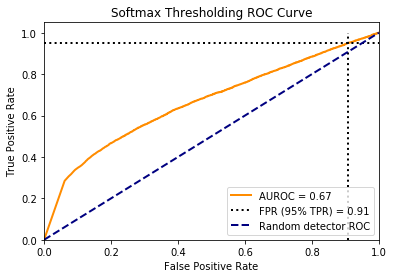

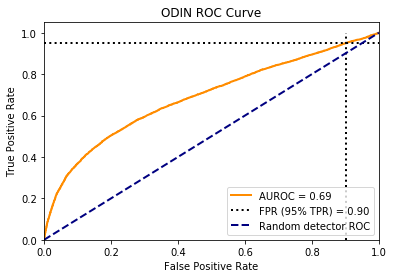

In [19]:
labels = [1] * num_inliers + [0] * num_lsun_resize
predictions = cifar_model_maximums + lsun_resize_model_maximums
predictions_odin = cifar_odin_maximums + lsun_resize_odin_maximums

results["WRN-28-10"]["outliers"]["LSUN (resize)"] = get_summary_statistics(predictions, labels)
results["WRN-28-10-ODIN"]["outliers"]["LSUN (resize)"] = get_summary_statistics(predictions_odin, labels)

df.loc['lsun_resize'] = pd.Series(results["WRN-28-10-ODIN"]["outliers"]["LSUN (resize)"])

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve")

### iSUN

In [20]:
isun_directory = '/media/tadenoud/DATADisk/datasets/isun'

# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
isun_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(isun_directory, transform=transform),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_isun = len(isun_loader.dataset)

# Get predictions on in-distribution images
isun_model_maximums = get_max_model_outputs(isun_loader, device)

temp = 1000
eps = 0.0002
cifar_odin_maximums = get_max_odin_outputs(test_loader, device, temp=temp, noiseMagnitude=eps)
isun_odin_maximums = get_max_odin_outputs(isun_loader, device, temp=temp, noiseMagnitude=eps)

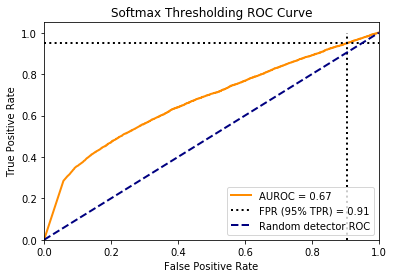

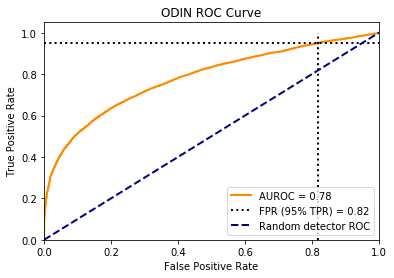

In [21]:
labels = [1] * num_inliers + [0] * num_isun
predictions = cifar_model_maximums + isun_model_maximums
predictions_odin = cifar_odin_maximums + isun_odin_maximums

results["WRN-28-10"]["outliers"]["iSUN"] = get_summary_statistics(predictions, labels)
results["WRN-28-10-ODIN"]["outliers"]["iSUN"] = get_summary_statistics(predictions_odin, labels)

df.loc['isun_resize'] = pd.Series(results["WRN-28-10-ODIN"]["outliers"]["iSUN"])

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve")

### Gaussian Noise Dataset

In [22]:
from novelty.utils.datasets import GaussianNoiseDataset

gaussian_transform = transforms.Compose([
    #TODO clip to [0,1] range
    transforms.ToTensor()
])

kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
gaussian_loader = torch.utils.data.DataLoader(
    GaussianNoiseDataset((10000, 32, 32, 3), mean=0., std=1., transform=gaussian_transform),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_gaussian = len(gaussian_loader.dataset)

# Get predictions on in-distribution images
gaussian_model_maximums = get_max_model_outputs(gaussian_loader, device)

temp = 1
eps = 0.0002
cifar_odin_maximums = get_max_odin_outputs(test_loader, device, temp=temp, noiseMagnitude=eps)
gaussian_odin_maximums = get_max_odin_outputs(
    gaussian_loader, device, temp=temp, noiseMagnitude=eps)

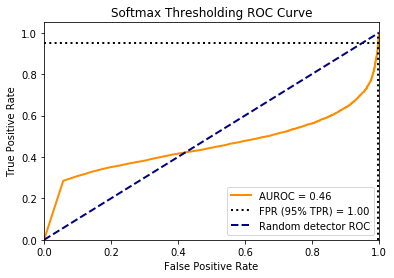

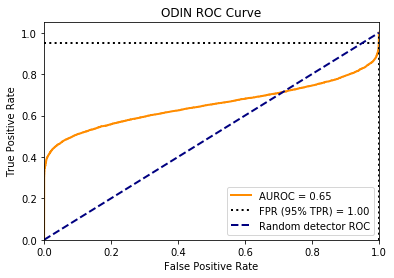

In [23]:
labels = [1] * num_inliers + [0] * num_gaussian
predictions = cifar_model_maximums + gaussian_model_maximums
predictions_odin = cifar_odin_maximums + gaussian_odin_maximums

results["WRN-28-10"]["outliers"]["Gaussian Noise"] = get_summary_statistics(predictions, labels)
results["WRN-28-10-ODIN"]["outliers"]["Gaussian Noise"] = get_summary_statistics(predictions_odin, labels)

df.loc['gaussian'] = pd.Series(results["WRN-28-10-ODIN"]["outliers"]["Gaussian Noise"])

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve")

### Uniform Noise Dataset

In [24]:
from novelty.utils.datasets import UniformNoiseDataset
import math

kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
uniform_loader = torch.utils.data.DataLoader(
    UniformNoiseDataset((10000, 32, 32, 3), low=-math.sqrt(3.), high=math.sqrt(3.), transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_uniform = len(uniform_loader.dataset)

# Get predictions on in-distribution images
uniform_model_maximums = get_max_model_outputs(uniform_loader, device)

temp = 1
eps = 0.0002
cifar_odin_maximums = get_max_odin_outputs(test_loader, device, temp=temp, noiseMagnitude=eps)
uniform_odin_maximums = get_max_odin_outputs(
    uniform_loader, device, temp=temp, noiseMagnitude=eps)

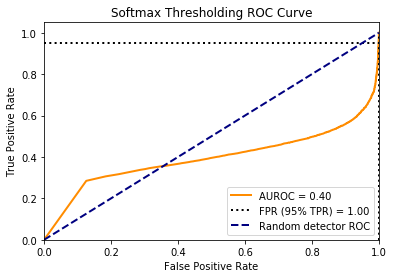

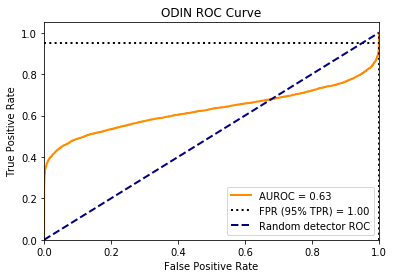

In [25]:
labels = [1] * num_inliers + [0] * num_uniform
predictions = cifar_model_maximums + uniform_model_maximums
predictions_odin = cifar_odin_maximums + uniform_odin_maximums

results["WRN-28-10"]["outliers"]["Uniform Noise"] = get_summary_statistics(predictions, labels)
results["WRN-28-10-ODIN"]["outliers"]["Uniform Noise"] = get_summary_statistics(predictions_odin, labels)

df.loc['uniform'] = pd.Series(results["WRN-28-10-ODIN"]["outliers"]["Uniform Noise"])

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve")

### CIFAR20

In [24]:
from novelty.utils.datasets import UniformNoiseDataset
import math

kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
num_cifar20 = len(test_loader.dataset)

# Get predictions on in-distribution images
cifar20_model_maximums = get_max_model_outputs(cifar20_loader, device)

temp = 1
eps = 5e-05
cifar_odin_maximums = get_max_odin_outputs(test_loader, device, temp=temp, noiseMagnitude=eps)
cifar20_odin_maximums = get_max_odin_outputs(
    test_loader, device, temp=temp, noiseMagnitude=eps)

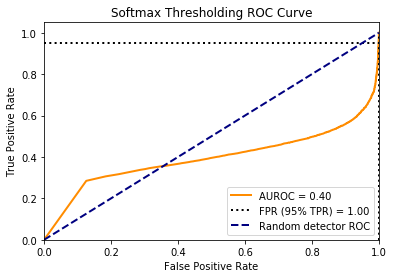

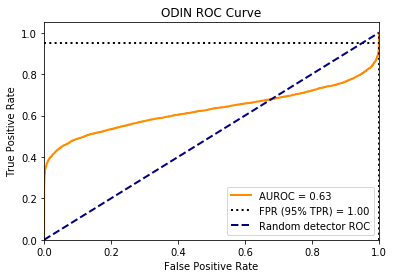

In [25]:
labels = [1] * num_inliers + [0] * num_uniform
predictions = cifar_model_maximums + uniform_model_maximums
predictions_odin = cifar_odin_maximums + uniform_odin_maximums

results["WRN-28-10"]["outliers"]["CIFAR20"] = get_summary_statistics(predictions, labels)
results["WRN-28-10-ODIN"]["outliers"]["CIFAR20"] = get_summary_statistics(predictions_odin, labels)

df.loc['cifar20'] = pd.Series(results["WRN-28-10-ODIN"]["outliers"]["CIFAR20"])

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")
    plot_roc(predictions_odin, labels, title="ODIN ROC Curve")

#     plot_prc(predictions, labels, title="Softmax Thresholding PRC Curve")
#     plot_prc(predictions_odin, labels, title="ODIN PRC Curve")

In [26]:
df.to_pickle('./cifar100_wrn28_10_odin.pkl')
df

,auroc,aupr_in,aupr_out,fpr_at_95_tpr,detection_error
imagenet_crop,0.812479,0.829943,0.781612,0.7252,0.3876
imagenet_resize,0.781906,0.795391,0.742655,0.7888,0.4194
lsun_crop,0.89159,0.903778,0.87828,0.5321,0.29105
lsun_resize,0.689599,0.712421,0.632512,0.9033,0.4766
isun_resize,0.781618,0.825909,0.704508,0.818936,0.434368
gaussian,0.65102,0.768268,0.533129,0.9998,0.5245
uniform,0.627934,0.752477,0.517226,0.9999,0.5222


# Show Results Table

In [27]:
from IPython.display import HTML, display

table = html_summary_table(results)
display(HTML(table))